In [1]:
import pandas as pd
import numpy as np
import scipy as sc


import warnings 
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
%pylab inline

import datetime
import dateutil.relativedelta

Populating the interactive namespace from numpy and matplotlib


In [75]:
# Загружаем фундаментальные переменные
initial = pd.read_excel('features_zero.xlsx') 
initial = initial.iloc[:-1, 1:]
initial['Year'] = initial['DataDate'].dt.year

# Загружаем макро переменные
macro = pd.read_excel('macro_merge.xlsx')
macro.rename(columns = {'Date' : 'DataDate'}, inplace = True)

# Загружаем технические индикаторы
tech = pd.read_excel('PCA_tech.xlsx')
tech = tech[['DataDate', 'company', 'label', 'tech_PCA_1',
       'tech_PCA_2', 'tech_PCA_3', 'tech_PCA_4', 'tech_PCA_5']]

In [76]:
initial = initial[['DataDate', 'company', 'label', 'Sector', 'current_ratio', 'icr',
       'std_coef', 'ebit/sales', 'ROCE', 'eva', 'sales_growth', 'cvadrant',
       'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 'Div/MV', 'Div Payout Ratio',
       'TSR']]

In [77]:
# На базе абсолютных фунд. показателей рассчитываем относительные time

list_of_features = ['current_ratio', 'icr', 'std_coef', 'ebit/sales', 'ROCE', 
                    'eva', 'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA']

for feature in list_of_features:
    initial[feature + '_time_rel'] = initial.groupby('company')[feature].apply(lambda x: np.log(x/x.shift(1)))
    initial[feature + '_time_rel'] = initial[feature + '_time_rel'].where(initial[feature + '_time_rel'] != inf, 0)
    initial[feature + '_time_rel'] = initial[feature + '_time_rel'].where(initial[feature + '_time_rel'] != -inf, 0)

In [78]:
initial = initial[initial.DataDate.dt.year > 2001]
initial.reset_index(drop=True, inplace = True)
initial['year'] = initial.DataDate.dt.year

In [79]:
list_of_features = ['current_ratio', 'icr', 'std_coef', 'ebit/sales', 'ROCE', 
                    'eva', 'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA']
for feature in list_of_features:
    mean = pd.DataFrame(initial.groupby(initial.DataDate.dt.year)[feature].median()).reset_index()
    mean.rename(columns = {'DataDate':'year', feature: feature + '_sec_mean'}, inplace = True)
    initial = pd.merge(initial, mean, on = ['year'], how = 'left')

In [80]:
list_of_features = ['current_ratio', 'icr', 'std_coef', 'ebit/sales', 'ROCE', 
                    'eva', 'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA']
for feature in list_of_features:
    initial[feature + '_sec_rel'] = np.log((initial[feature] / initial[feature + '_sec_mean']))
    initial[feature + '_sec_rel'] = initial[feature + '_sec_rel'].where(initial[feature + '_sec_rel'] != inf, 0)
    initial[feature + '_sec_rel'] = initial[feature + '_sec_rel'].where(initial[feature + '_sec_rel'] != -inf, 0)

In [81]:
initial = initial[['DataDate', 'company', 'label', 'Sector', 'current_ratio', 'icr',
       'std_coef', 'ebit/sales', 'ROCE', 'eva', 'sales_growth', 'cvadrant',
       'NA', 'BV/MV', 'EBITDA/EV', 'Debt/EBITDA', 'Div/MV', 'Div Payout Ratio',
       'TSR', 'current_ratio_time_rel', 'icr_time_rel', 'std_coef_time_rel',
       'ebit/sales_time_rel', 'ROCE_time_rel', 'eva_time_rel', 'NA_time_rel',
       'BV/MV_time_rel', 'EBITDA/EV_time_rel', 'Debt/EBITDA_time_rel', 
       'current_ratio_sec_rel', 'icr_sec_rel', 'std_coef_sec_rel',
       'ebit/sales_sec_rel', 'ROCE_sec_rel', 'eva_sec_rel', 'NA_sec_rel',
       'BV/MV_sec_rel', 'EBITDA/EV_sec_rel', 'Debt/EBITDA_sec_rel']]

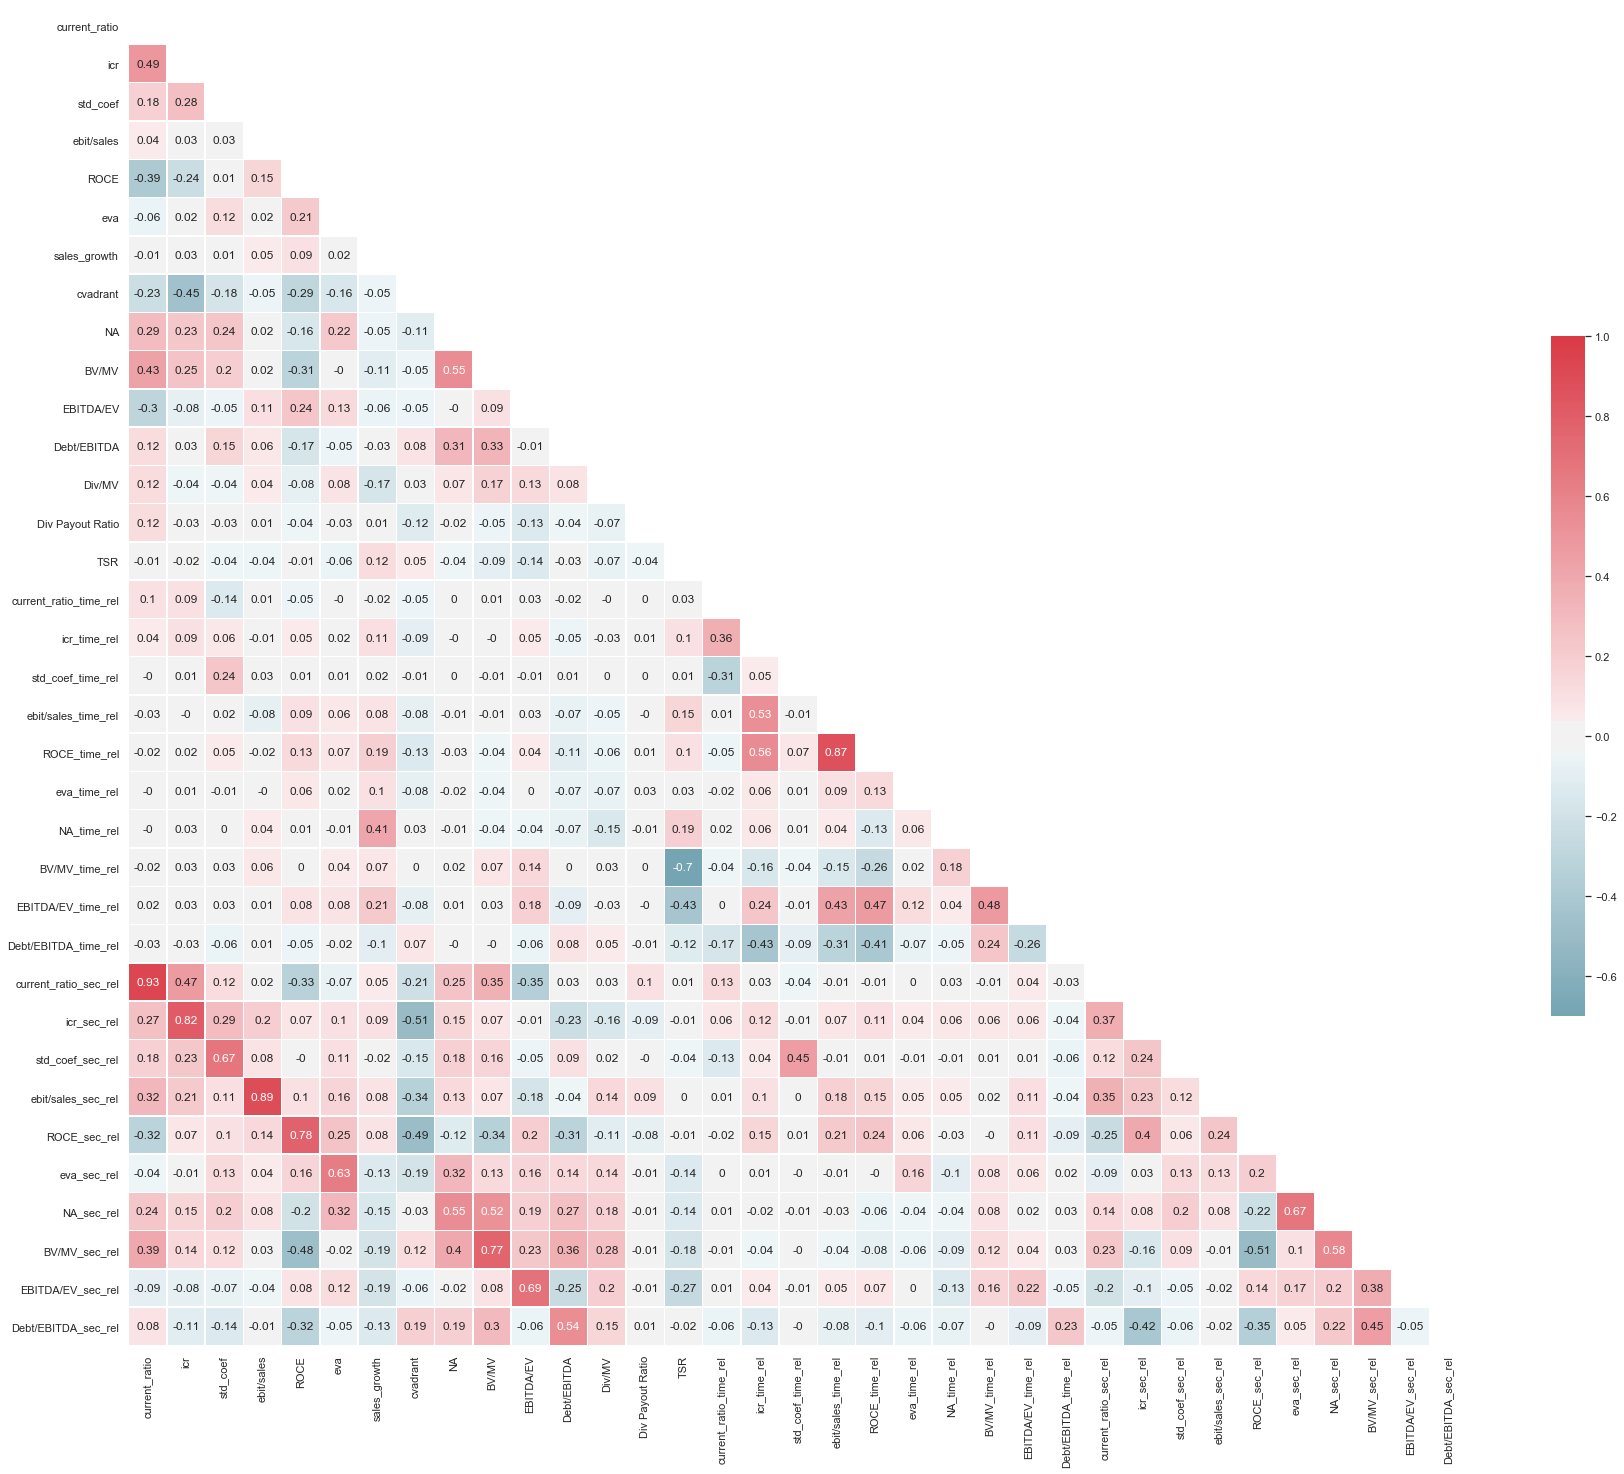

In [84]:
%config InlineBackend.figure_format = 'png' 
sns.set(style="white")

# Compute the correlation matrix
corr = round(initial.corr(), 2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center = 0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [90]:
# Заполняем NAN
initial_mean = initial.fillna(initial.mean())
initial_mean.reset_index(inplace = True)

In [93]:
initial_mean.shape

(5910, 40)

In [94]:
# Объединяем таблицы macro and initial

model = pd.merge(initial_mean, macro, how = 'left' , on = 'DataDate')
model.drop_duplicates(inplace = True)
model.dropna(inplace = True)
model.reset_index(inplace = True, drop = True)

In [95]:
model.shape

(5787, 48)

In [96]:
# Добавляем tech

model = pd.merge(model, tech, how = 'left' , on = ['DataDate', 'company', 'label'])
model.drop_duplicates(inplace = True)
model.dropna(inplace = True)
model.reset_index(inplace = True, drop = True)

In [97]:
model.shape

(5665, 53)

In [98]:
# Проверка на дубликаты
l = model[['company', 'Sector', 'DataDate']]
index = l[l.duplicated(keep=False)].index
print(model.iloc[index, :].index)
print(model.shape)

Int64Index([], dtype='int64')
(5665, 53)


In [99]:
# Загружаем рыночные доходности 

dd = pd.read_excel('New_Market_Data.xlsx')
dd.drop(columns = ['Unnamed: 0'], inplace = True)

In [100]:
# Добавляем рыночные доходности 

dd = dd[['DataDate', 'company','Sector', 'shifted_1', 'shifted_3', 'shifted_6', 'shifted_12', 'shifted_1_sec',
         'shifted_3_sec', 'shifted_6_sec', 'shifted_12_sec']]
model_test = pd.merge(model, dd, how = 'left' , on = ['DataDate', 'company', 'Sector'])
model_test.drop_duplicates(inplace = True)
model_test.dropna(inplace = True)
model_test.reset_index(inplace = True, drop = True)
model = model_test

In [102]:
# Проверка на дубликаты
l = model_test[['company', 'DataDate']]
index = l[l.duplicated(keep=False)].index
print(model_test.iloc[index, :].index)
print(model_test.shape)

Int64Index([], dtype='int64')
(5227, 61)


In [106]:
model_test.drop(columns = ['index'], inplace = True)

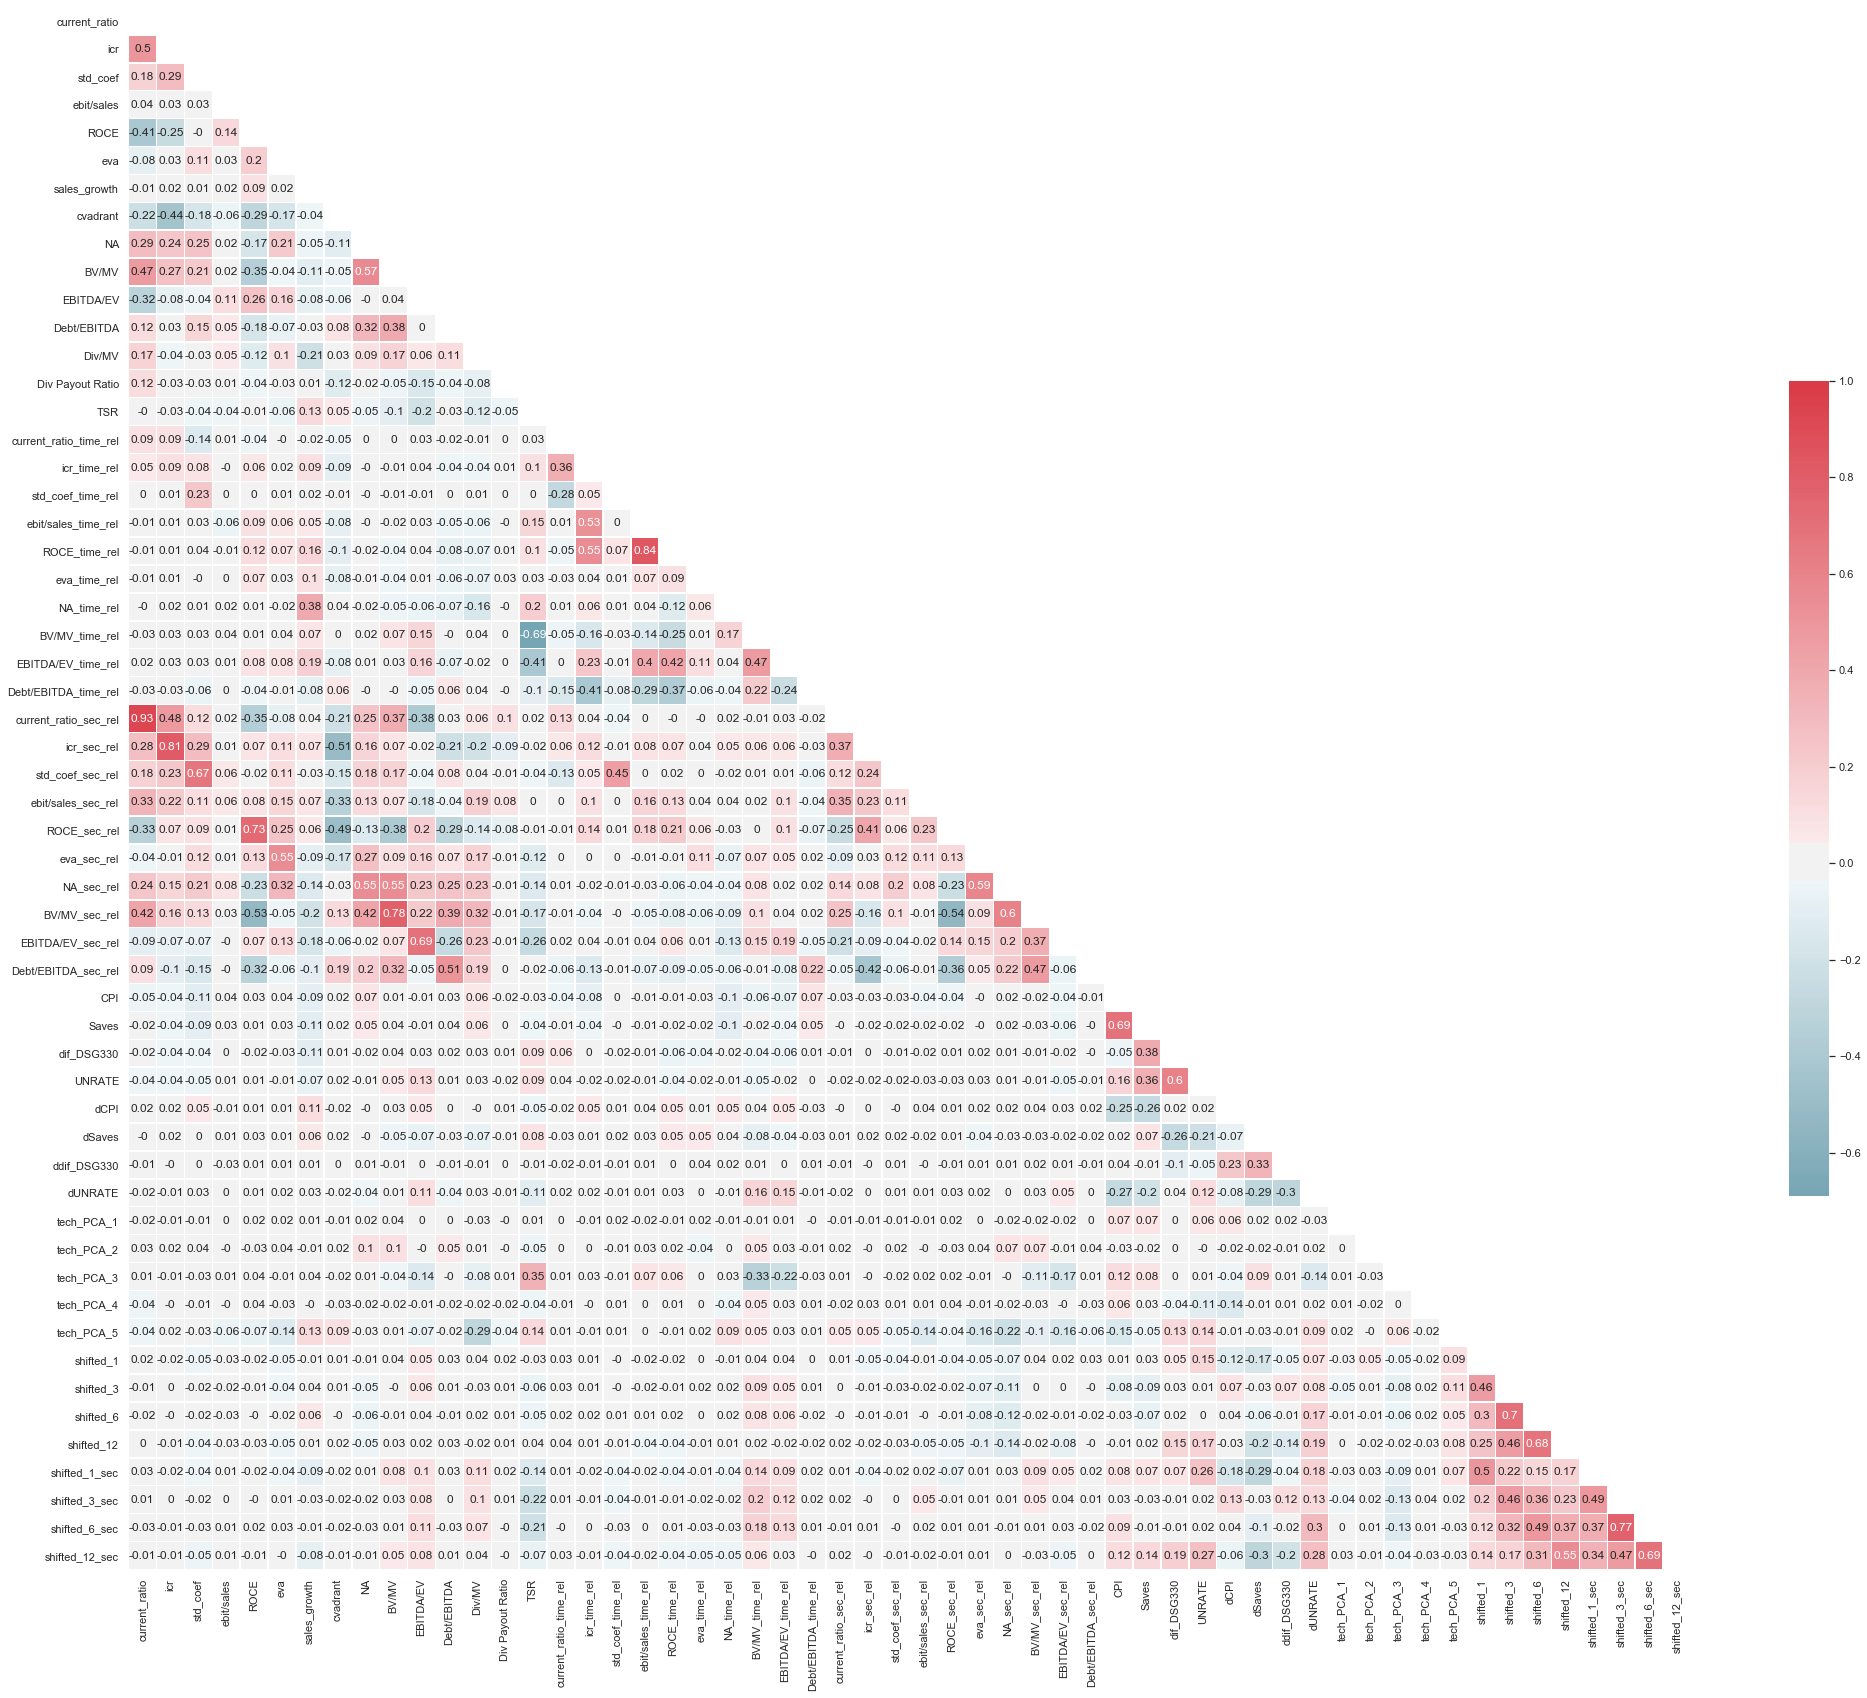

In [108]:
%config InlineBackend.figure_format = 'png' 
sns.set(style="white")

# Compute the correlation matrix
corr = round(model_test.corr(), 2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(35, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center = 0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()

In [109]:
model_test.to_excel('model_data.xlsx')